In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
import numpy as np
import random
import numpy.random as npr
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.image as img
from matplotlib import offsetbox
from PIL import Image
import shutil 
import pandas as pd
import zipfile as zf
from tqdm.auto import tqdm
import yaml
import collections
import json
import random
import matplotlib.patches as patches
import pickle
import cv2
import time
import os
import copy
import math
from time import time
import warnings
%matplotlib inline
plt.style.use('bmh')
warnings.filterwarnings('ignore')

In [5]:
num_of_gpus = torch.cuda.device_count()
print(num_of_gpus)

5


### Social Behavioral Analysis

In [6]:
def classs_arr(label):
    if label == int(1):
        label = 0
    elif label == int(2):
        label = 1 
    else:
        label = 2
    return label

In [7]:
def load_images_labels(df,path):
    X , t =[],[]
    print("Found {} Images".format(len(os.listdir(path))))
    for i in range(len(df)):
        if df['image'][i]:
            img = cv2.imread(path+'/'+df['image'][i])
            X.append(np.array(img).reshape((3,330,600)))
            t.append(int(classs_arr(df['behaviour'][i])))
        else:
            break
    print("Processed all the Images and their corresponding attributes")
    return np.array(X),np.array(t)        

In [8]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data).float()
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

In [9]:
class ResNetClassifier(nn.Module):
    def __init__(self, labels=3):
        super(ResNetClassifier, self).__init__()
        self.resnet = models.resnet101(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, labels)

    def forward(self, x):
        x = self.resnet(x)
        return x

In [10]:
PATH = './MBAS-ResNet-101-CLS.pth'
model = torch.load(PATH)
model = model.to(device)

In [11]:
val_df = pd.read_csv('Val.csv')
val_df = val_df.drop(columns=['m1x2','m1y2','m1x3','m1y3','m1x4','m1y4','m1x5','m1y5','m1x6','m1y6','m1x7','m1y7','m2x1','m2y1','m2x2','m2y2','m2x3','m2y3','m2x4','m2y4','m2x5','m2y5','m2x6','m2y6'])
val_df = val_df.dropna(how='any')
val_df

,image,m1x1,m1y1,m2x7,m2y7,behaviour
0,mouse071_frameno_1.jpg,422,192,445,200,3
1,mouse071_frameno_2.jpg,430,194,446,203,1
2,mouse071_frameno_3.jpg,435,193,448,206,1
3,mouse071_frameno_4.jpg,440,195,449,208,1
4,mouse071_frameno_5.jpg,442,198,451,209,1
...,...,...,...,...,...,...
41969,mouse072_frameno_18160.jpg,133,132,511,216,3
41970,mouse072_frameno_18161.jpg,126,136,510,215,3
41971,mouse072_frameno_18162.jpg,121,140,509,215,3
41972,mouse072_frameno_18163.jpg,116,144,510,215,3


In [12]:
X,y = load_images_labels(val_df,os.path.join(os.getcwd(),'Images','test'))

Found 41974 Images
Processed all the Images and their corresponding attributes


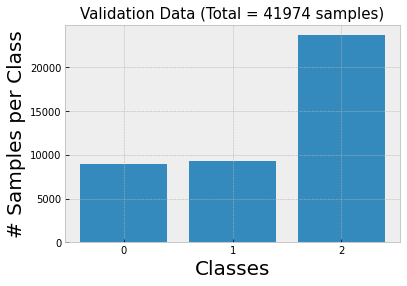

In [13]:
vals, counts = np.unique(y, return_counts=True)

plt.bar(vals, counts)
plt.xticks(range(3),range(3))
plt.xlabel('Classes',size=20)
plt.ylabel('# Samples per Class', size=20)
plt.title('Validation Data (Total = '+str(len(y))+' samples)',size=15);

In [14]:
val_dataset = CustomDataset(X, y)

In [15]:
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [45]:
avg=[]
model.eval()   # Set model to evaluate mode
iter=0
for inputs, labels in val_dataloader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, predicted = torch.max(outputs, 1)
    
      labels =labels.to(device)
      pred = predicted.to(device)
      labels =labels.cpu().numpy()
      pred =pred.cpu().numpy()
      acc =  100.0 * accuracy_score(labels,pred)
      avg.append(acc)
      print('Validation Accuracy of the network for iteration {0}: {1} %'.format(iter,acc))
      iter+=1
print("Average Validation Accuracy of the network",sum(avg)//iter)

Validation Accuracy of the network for iteration 0: 93.75 %
Validation Accuracy of the network for iteration 1: 100.0 %
Validation Accuracy of the network for iteration 2: 100.0 %
Validation Accuracy of the network for iteration 3: 100.0 %
Validation Accuracy of the network for iteration 4: 100.0 %
Validation Accuracy of the network for iteration 5: 100.0 %
Validation Accuracy of the network for iteration 6: 100.0 %
Validation Accuracy of the network for iteration 7: 100.0 %
Validation Accuracy of the network for iteration 8: 100.0 %
Validation Accuracy of the network for iteration 9: 100.0 %
Validation Accuracy of the network for iteration 10: 100.0 %
Validation Accuracy of the network for iteration 11: 100.0 %
Validation Accuracy of the network for iteration 12: 100.0 %
Validation Accuracy of the network for iteration 13: 100.0 %
Validation Accuracy of the network for iteration 14: 93.75 %
Validation Accuracy of the network for iteration 15: 100.0 %
Validation Accuracy of the network

### Anaotmical Key Points Estimation

In [20]:
def load_images_vectors(df,path):
    X , t =[],[]
    print("Found {} Images".format(len(os.listdir(path))))
    for i in range(len(df)):
        if df['image'][i]:
            img = cv2.imread(path+'/'+df['image'][i])
            X.append(np.array(img).reshape((3,330,600)))
            t.append(np.array([df['m1x1'][i],df['m1y1'][i],df['m2x7'][i],df['m2y7'][i]]))
        else:
            break
    print("Processed all the Images and their corresponding attributes")
    return np.array(X),np.array(t)   

In [21]:
class CustomDataset(Dataset):
    def __init__(self, data, vectors):
        self.data = torch.tensor(data).float()
        self.vectors = torch.tensor(vectors).float()

    def __len__(self):
        return len(self.vectors)

    def __getitem__(self, index):
        return self.data[index], self.vectors[index]

In [22]:
class ResNetRegression(nn.Module):
    def __init__(self, vectors=4):
        super(ResNetRegression, self).__init__()
        self.resnet = models.resnet101(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, vectors)

    def forward(self, x):
        x = self.resnet(x)
        return x

In [23]:
PATH = './MBAS-ResNet-101-Reg.pth'
model = torch.load(PATH)
model = model.to(device)

In [24]:
val_df = pd.read_csv('Val.csv')
val_df =val_df.drop(columns=['behaviour'])
val_df

,image,m1x1,m1y1,m1x2,m1y2,m1x3,m1y3,m1x4,m1y4,m1x5,...,m2x3,m2y3,m2x4,m2y4,m2x5,m2y5,m2x6,m2y6,m2x7,m2y7
0,mouse071_frameno_1.jpg,422,192,384,184,410,150,388,160,323,...,512,255,498,256,458,237,487,204,445,200
1,mouse071_frameno_2.jpg,430,194,389,188,413,153,392,164,325,...,511,257,496,259,457,241,488,208,446,203
2,mouse071_frameno_3.jpg,435,193,393,193,415,156,396,167,328,...,512,259,498,261,458,243,488,211,448,206
3,mouse071_frameno_4.jpg,440,195,398,196,419,159,399,170,333,...,513,259,499,259,459,245,489,212,449,208
4,mouse071_frameno_5.jpg,442,198,403,198,423,162,403,172,338,...,513,256,496,256,458,244,489,213,451,209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41969,mouse072_frameno_18160.jpg,133,132,86,129,113,97,94,108,57,...,517,269,500,263,484,232,524,236,511,216
41970,mouse072_frameno_18161.jpg,126,136,84,125,115,99,95,106,57,...,515,269,499,262,483,231,524,236,510,215
41971,mouse072_frameno_18162.jpg,121,140,80,124,115,103,94,107,57,...,515,269,499,263,483,232,524,236,509,215
41972,mouse072_frameno_18163.jpg,116,144,78,123,115,106,92,108,58,...,515,269,499,262,483,230,524,236,510,215


In [25]:
X,y = load_images_vectors(val_df,os.path.join(os.getcwd(),'Images','test'))

Found 41974 Images
Processed all the Images and their corresponding attributes


In [26]:
val_dataset = CustomDataset(X, y)

In [27]:
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [28]:
avg=[]
res1,res2,res3,res4 =[],[],[],[]
model.eval()   # Set model to evaluate mode
iter=0
for inputs, vectors in val_dataloader:
      inputs = inputs.to(device)
      vectors = vectors.to(device)
      outputs = model(inputs)
      outputs = torch.Tensor.round(outputs)
      vectors =vectors.to(device)
      pred = outputs.to(device)
      vectors =vectors.cpu().numpy()
      pred =pred.detach().cpu().numpy()
      res1.append(pred[0][0])
      res2.append(pred[0][1])
      res3.append(pred[0][2])
      res4.append(pred[0][3])
      iter+=1
print("Network Prediction is Completed")

Network Prediction is Completed


In [29]:
pred_df = pd.DataFrame()
pred_df['image'] = val_df['image']
pred_df['m1x1'] = np.array(res1)
pred_df['m1y1'] = np.array(res2)
pred_df['m2x7'] = np.array(res3)
pred_df['m2y7'] = np.array(res4)
pred_df

,image,m1x1,m1y1,m2x7,m2y7
0,mouse071_frameno_1.jpg,194.0,134.0,210.0,95.0
1,mouse071_frameno_2.jpg,202.0,133.0,210.0,98.0
2,mouse071_frameno_3.jpg,203.0,142.0,218.0,93.0
3,mouse071_frameno_4.jpg,217.0,139.0,243.0,82.0
4,mouse071_frameno_5.jpg,218.0,139.0,222.0,89.0
...,...,...,...,...,...
41969,mouse072_frameno_18160.jpg,317.0,185.0,255.0,78.0
41970,mouse072_frameno_18161.jpg,288.0,175.0,236.0,78.0
41971,mouse072_frameno_18162.jpg,285.0,172.0,236.0,79.0
41972,mouse072_frameno_18163.jpg,284.0,173.0,238.0,80.0


In [30]:
pred_df.to_csv('Pred.csv')